# Prepare Required Files and Dependencies

Full dataset is available at [https://ritsumei365-my.sharepoint.com/:u:/g/personal/gr0609fv_ed_ritsumei_ac_jp/EYS6Pu3_90ZLv9To2RgpEioBjpGQjUTMlks6IdPfT4ZlEA?e=kVuEfg](https://ritsumei365-my.sharepoint.com/:u:/g/personal/gr0609fv_ed_ritsumei_ac_jp/EYS6Pu3_90ZLv9To2RgpEioBjpGQjUTMlks6IdPfT4ZlEA?e=kVuEfg)

In [2]:
!git clone https://github.com/dmc27/missing_pixels.git

Cloning into 'missing_pixels'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 59 (delta 0), reused 0 (delta 0), pack-reused 56
Unpacking objects: 100% (59/59), 11.59 MiB | 9.59 MiB/s, done.


In [3]:
from os import listdir
from os.path import isfile

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import ModelCheckpoint

from utils import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [5]:
img_path = "/kaggle/input/tiny-imagenet/datasets"
img_fnames = [f for f in listdir(img_path) if isfile(join(img_path, f))]
print(img_fnames[:20])

['4db37247-6925-402c-a42e-344f2db926d1.JPEG', '10b87bba-5456-4357-a266-fffce92dc7b9.JPEG', '5b72ca04-a7f1-4df4-a3fd-6a6eb39e887d.JPEG', 'ef08d6d1-919f-4d54-8759-298ceb79b519.JPEG', '9cb00618-6c4b-4add-9fac-fa2090f05d17.JPEG', '8a8d7980-d8c7-4e34-b3b3-5084ad82636c.JPEG', '28895932-9f8e-4596-9ea6-cadfd26bd25d.JPEG', '9d9a0a17-42db-4a6a-811f-b624ccbcce09.JPEG', '93bf6d0e-d14c-4ed5-b705-079d99ed0492.JPEG', '9492f8b4-a096-47ed-805f-6c71329b8370.JPEG', '3082111f-bc0f-4d8f-afd9-e4ce241fcf3d.JPEG', '8362d2b8-81df-4b0a-a3ac-ac59cda2ec36.JPEG', '0da0a49a-cf50-46c8-9b60-70ef45890d44.JPEG', 'af060a07-2cd1-4b2d-91f2-f487ecdea781.JPEG', '0a196d51-b78d-4535-b9cc-f2a4b571ef3e.JPEG', '0a17f9fe-22b6-44d6-890b-bc22910f613c.JPEG', '1adbde46-9403-4d5f-ab6b-621dce9d4f54.JPEG', 'bdade303-ead0-4d11-93a4-9488ba9cd703.JPEG', 'd5c2eb55-5f51-4288-862f-56144cf5dff6.JPEG', '1a39045e-636a-4f98-8bf1-38429a3f03c6.JPEG']


In [6]:
inputs = []
targets = []
for img_fname in img_fnames:
    img = cv.imread(join(img_path, img_fname), cv.IMREAD_GRAYSCALE)
    img = img.astype(np.float64)

    do_parse_img(img, inputs, targets)

X_train = np.zeros((len(inputs), NUM_INP_NODES))
y_train = np.zeros((len(targets), NUM_OUT_NODES))
for idx in range(len(inputs)):
    X_train[idx, :] = inputs[idx]
    y_train[idx] = targets[idx]

In [7]:
print(X_train.shape)

(7680000, 60)


# Modeling

In [8]:
model_fname = "models/model.mlp.imagenet.h5"

model = Sequential([
    Dense(120, input_shape=(NUM_INP_NODES,), activation="relu"),
    Dense(60, activation="relu"),
    Dense(NUM_OUT_NODES, activation='sigmoid')
])

model.compile(loss="mean_squared_error", optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               7320      
                                                                 
 dense_1 (Dense)             (None, 60)                7260      
                                                                 
 dense_2 (Dense)             (None, 4)                 244       
                                                                 
Total params: 14,824
Trainable params: 14,824
Non-trainable params: 0
_________________________________________________________________


In [9]:
checkpoint = ModelCheckpoint(model_fname, monitor='loss', verbose=1,
                             save_best_only=True)
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=100, batch_size=512,
                    validation_split=0.1, callbacks=callbacks_list)

Epoch 1/100
13495/13500 [============================>.] - ETA: 0s - loss: 0.0099 - accuracy: 0.4427
Epoch 1: loss improved from inf to 0.00990, saving model to models/model.mlp.imagenet.h5
13500/13500 [==============================] - 57s 4ms/step - loss: 0.0099 - accuracy: 0.4427 - val_loss: 0.0093 - val_accuracy: 0.4246
Epoch 2/100
13496/13500 [============================>.] - ETA: 0s - loss: 0.0090 - accuracy: 0.4710
Epoch 2: loss improved from 0.00990 to 0.00898, saving model to models/model.mlp.imagenet.h5
13500/13500 [==============================] - 55s 4ms/step - loss: 0.0090 - accuracy: 0.4710 - val_loss: 0.0087 - val_accuracy: 0.5660
Epoch 3/100
13495/13500 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.5902
Epoch 3: loss improved from 0.00898 to 0.00713, saving model to models/model.mlp.imagenet.h5
13500/13500 [==============================] - 57s 4ms/step - loss: 0.0071 - accuracy: 0.5902 - val_loss: 0.0058 - val_accuracy: 0.6056
Epoch 4/100
13

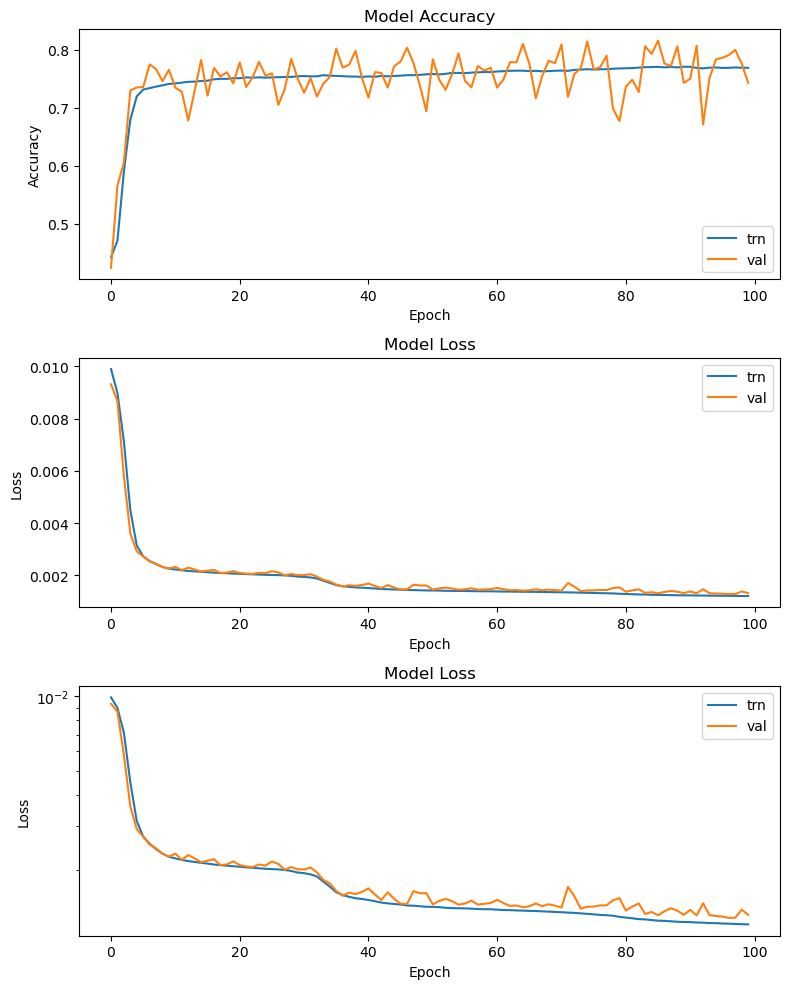

In [10]:
plot_training_history(history)

# Evaluation

32/32 [==============================] - 0s 1ms/step
MSE = 0.00


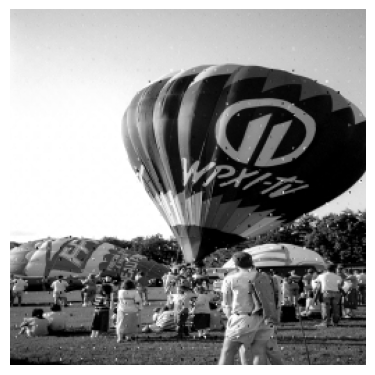

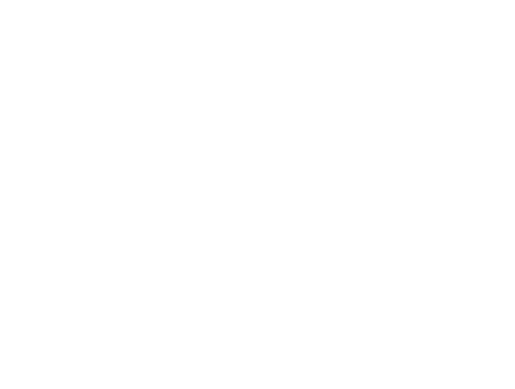

In [11]:
evaluate_mlp(model, out_file_path="/kaggle/working/missing_pixels/balloon.bmp")